In [2]:
# Import the necessary packages
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt
import numpy as np
import seaborn as sns
import os

In [3]:
# Set the working directory for where the AWS data is stored
os.chdir('/Users/f67f911/Desktop/Hourglass_WX/Data')

In [67]:
hourly = read_csv('Cleaned/hg_hourly_snowDepth.csv', header=0, index_col=0)
hourly.head()

,Timestamp,SnowDepth_m
1,2021-01-14 15:00:00,0.957
2,2021-01-14 16:00:00,0.959
3,2021-01-14 17:00:00,0.958
4,2021-01-14 18:00:00,0.953
5,2021-01-14 19:00:00,0.951


In [68]:
# First, we need to filter to ONLY include our field season
season_start = '2021-10-01'
season_end = '2022-06-31'

In [69]:
# Now create a mask and filter the hourly data by this same period
mask_season = (hourly['Timestamp'] >= season_start) & (hourly['Timestamp'] <= season_end)
season_df = hourly.loc[mask_season]
season_df.head()

,Timestamp,SnowDepth_m
6226,2021-10-01 00:00:00,0.584
6227,2021-10-01 01:00:00,0.579
6228,2021-10-01 02:00:00,0.591
6229,2021-10-01 03:00:00,0.585
6230,2021-10-01 04:00:00,0.524


In [70]:
# Set the index to the Timestamp column
season_df = season_df.set_index('Timestamp')

In [81]:
# Make sure the index is in datetime format
season_df.index= pd.to_datetime(season_df.index)
season_df.head()

,SnowDepth_m
Timestamp,
2021-10-01 00:00:00,0.584
2021-10-01 01:00:00,0.579
2021-10-01 02:00:00,0.591
2021-10-01 03:00:00,0.585
2021-10-01 04:00:00,0.524


In [76]:
# Aggregate to capture daily average snow depth based on the Hourly data
daily = season_df.resample('D').mean()

In [77]:
# Set the daily data equal to series
series = daily

In [79]:
series

,SnowDepth_m
Timestamp,
2021-10-01,0.356917
2021-10-02,0.222174
2021-10-03,0.301889
2021-10-04,0.243278
2021-10-05,0.262000
...,...
2022-06-26,0.185500
2022-06-27,NaN
2022-06-28,NaN


In [80]:
series['SnowDepth_m'] = np.where((0 <= series['SnowDepth_m']) & (series['SnowDepth_m'] < 2.3), series['SnowDepth_m'], np.nan)

<Axes: xlabel='Timestamp'>

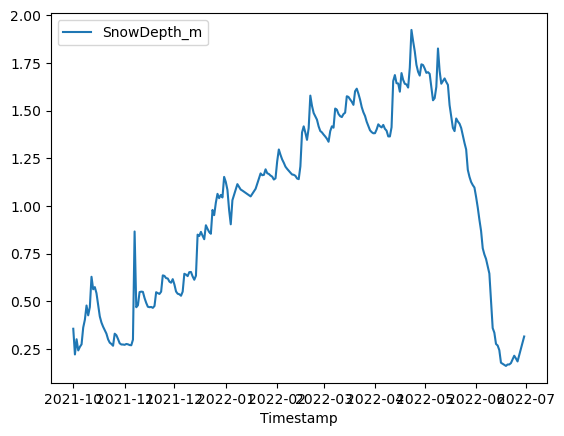

In [82]:
sns.lineplot(data = series)

In [83]:
# View the dates of the seasonal max
season_max = (series[series.SnowDepth_m == series.SnowDepth_m.max()])
season_max

,SnowDepth_m
Timestamp,
2022-04-23,1.924


In [89]:
# Reset the index so we have two distinct columns
daily_df = series.reset_index()
daily_df.head()

,Timestamp,SnowDepth_m
0,2021-10-01,0.356917
1,2021-10-02,0.222174
2,2021-10-03,0.301889
3,2021-10-04,0.243278
4,2021-10-05,0.262000


In [85]:
# Create a list of the snow_off dates that we wish to set to zero 
# These are NAN values that we know are actually equal to zero
snow_off_dates = pd.date_range('2021-10-01','2021-10-11',freq='d')
print(snow_off_dates)

DatetimeIndex(['2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
               '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
               '2021-10-09', '2021-10-10', '2021-10-11'],
              dtype='datetime64[ns]', freq='D')


In [86]:
# Append the list for values in June where we know there is no snow
snow_off_dates = snow_off_dates.append(pd.date_range('2022-06-25','2022-06-30',freq = 'd'))

In [91]:
# Run a loop to set values for snow depth in the season_df to zero if they match the known snow off dates at the 
# beginning and end of the field season
y = 0

for date in daily_df['Timestamp']:
    z = str(date)
    z = z.split(' ')[0]
    for x in snow_off_dates:
        c = str(x)
        c = c.split(' ')[0]
        if z == c:
            daily_df.iat[y,1] = 0
    y = y+1  

In [92]:
# Interpolate the missing values
daily_df = daily_df.interpolate()
daily_df.head()

,Timestamp,SnowDepth_m
0,2021-10-01,0.0
1,2021-10-02,0.0
2,2021-10-03,0.0
3,2021-10-04,0.0
4,2021-10-05,0.0


<Axes: xlabel='Timestamp', ylabel='SnowDepth_m'>

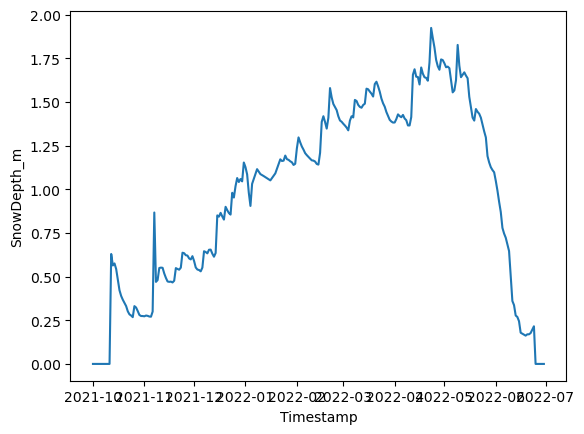

In [93]:
sns.lineplot(data = daily_df, x = 'Timestamp', y = 'SnowDepth_m')

In [94]:
# View the dates of the seasonal max
season_max = (daily_df[daily_df.SnowDepth_m == daily_df.SnowDepth_m.max()])
season_max

,Timestamp,SnowDepth_m
204,2022-04-23,1.924


In [97]:
daily_df.head()

,Timestamp,SnowDepth_m
0,2021-10-01,0.0
1,2021-10-02,0.0
2,2021-10-03,0.0
3,2021-10-04,0.0
4,2021-10-05,0.0


In [98]:
# Export the corrected snow depth data
daily_df.to_csv('Cleaned/seasonal_SDepth_Filled.csv', index = False)

------------------------------------------------------------------------------------------